# CLIP

##Clip Model

In [ ]:
# https://huggingface.co/docs/transformers/en/model_doc/clip

import torch
from transformers import CLIPProcessor, CLIPModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


cpu


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

## Video Search

### Download Video

In [ ]:
!pip install -U yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 15.2 MB/s eta 0:00:00


In [ ]:
# lion king trailer
# !yt-dlp -F https://www.youtube.com/watch?v=7TavVZMewpY - finds available formats

!yt-dlp -f 136 -o /content/drive/MyDrive/CS445/final_project/lion_king.mp4 https://www.youtube.com/watch?v=7TavVZMewpY

[youtube] Extracting URL: https://www.youtube.com/watch?v=7TavVZMewpY
[youtube] 7TavVZMewpY: Downloading webpage
[youtube] 7TavVZMewpY: Downloading ios player API JSON
[youtube] 7TavVZMewpY: Downloading android player API JSON
[youtube] 7TavVZMewpY: Downloading player 5d0dbf62
[youtube] 7TavVZMewpY: Downloading m3u8 information
[info] 7TavVZMewpY: Downloading 1 format(s): 136
[download] /content/drive/MyDrive/CS445/final_project/lion_king.mp4 has already been downloaded
[download] 100% of    1.23MiB


### Extract Frames

In [ ]:
import cv2
import numpy as np
from tqdm.auto import tqdm

video = cv2.VideoCapture('/content/drive/MyDrive/CS445/final_project/lion_king.mp4')

total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(video.get(cv2.CAP_PROP_FPS))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
channels = 3

num_frames, frames = 0, None
for i in tqdm(range(total_frames)):
    ret, frame = video.read()
    # every 0.5 second, otherwise processing takes too long
    if i % (fps//2) == 0:
        frame = frame[np.newaxis, :]
        frames = frame if frames is None else np.concatenate((frames,frame), axis=0)
        num_frames += 1

video.release()

  0%|          | 0/2606 [00:00<?, ?it/s]

### Search with Clip

In [ ]:
# inspired by Video Google? lecture 12

batch_size = 32
search_text = ["Lion on a cliff", "Birds above water", "Gazelles jumping"]

# clip inference
logits = np.zeros((num_frames,len(search_text)))

# extract text features
text_features = clip_processor(text=search_text, return_tensors="pt", padding=True)
input_ids = text_features['input_ids'].to(device)
attention_mask = text_features['attention_mask'].to(device)

# extract image features
image_features = clip_processor(images=frames, return_tensors="pt", padding=True)
pixel_values = image_features['pixel_values'].to(device)

# needed to avoid out of memory errors
for i in tqdm(range((num_frames-1)//batch_size+1)):

    start_idx, end_idx = i*batch_size, min((i+1)*batch_size,num_frames)

    # feed into model
    outputs = clip_model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values[start_idx: end_idx])
    logits[start_idx: end_idx] = outputs.logits_per_image.detach().to('cpu')



  0%|          | 0/8 [00:00<?, ?it/s]

### Clip Results

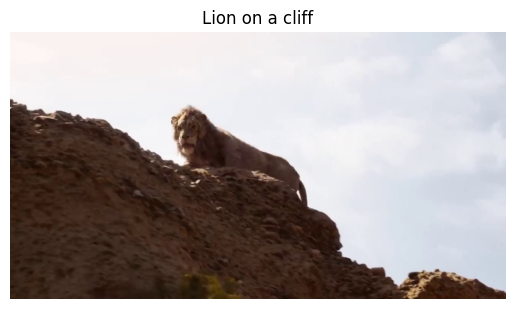

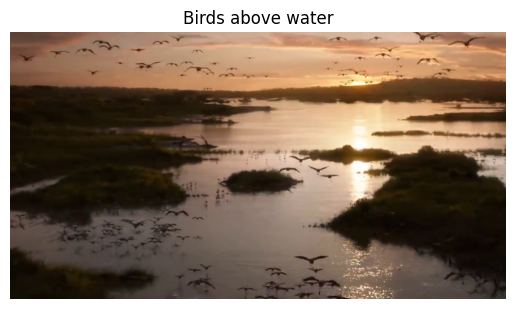

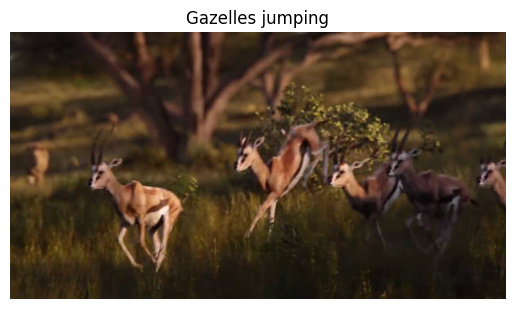

In [ ]:
from matplotlib import pyplot as plt

image_idx = np.argmax(logits, axis=0)

for i, img in enumerate(image_idx):
    plt.figure()
    plt.title(search_text[i])
    plt.axis('off')
    plt.imshow(frames[img][:,:,[2,1,0]]);